# Telecom Churn Analysis and Prediction

In [1]:
import os, sys

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import math
from collections import Counter
from numpy import where
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

<a id="import-and-clean-data"></a>
# 1.  Import and Clean data

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


<a id="delete-%60customerid%60-column"></a>
## 1.1.  Delete `customerid` column
Since 'customerid' column does not provide any relevant information in predicting the customer churn, we can delete the column.

In [4]:
df.drop(labels=['customerID'], axis=1, inplace=True)
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


<a id="data-munging"></a>
## 1.2.  Data Munging

<a id="checking-for-null-values-in-the-dataset"></a>
### 1.2.1.  Checking for null values in the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


As of now we don't see any null values. However, we will find a few in the `TotalCharges` column after casting it to `float64`

<a id="making-labels-concise"></a>
### 1.2.2.  Making labels concise
Let's make the categorical labels more concise. For instance, we will convert the categorical label `'Bank transfer (automatic)'` to `'Bank transfer'` to make it easier to access (and display) during visualization.

In [6]:
## Shorten the Labels
value_mapper = {'Female': 'F', 'Male': 'M', 'Yes': 'Y', 'No': 'N',
                'No phone service': 'No phone', 'Fiber optic': 'Fiber',
                'No internet service': 'No internet', 'Month-to-month': 'Monthly',
                'Bank transfer (automatic)': 'Bank transfer',
                'Credit card (automatic)': 'Credit card',
                'One year': '1 yr', 'Two year': '2 yr'}
df.replace(to_replace=value_mapper, inplace=True)

Let's also change column labels from `TitleCase` to `lowercase` to ease access.

In [7]:
df.columns = [label.lower() for label in df.columns]
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
gender,F,M,M,M,F,F,M,F,F,M
seniorcitizen,0,0,0,0,0,0,0,0,0,0
partner,Y,N,N,N,N,N,N,N,Y,N
dependents,N,N,N,N,N,N,Y,N,N,Y
tenure,1,34,2,45,2,8,22,10,28,62
phoneservice,N,Y,Y,N,Y,Y,Y,N,Y,Y
multiplelines,No phone,N,N,No phone,N,Y,Y,No phone,Y,N
internetservice,DSL,DSL,DSL,DSL,Fiber,Fiber,Fiber,DSL,Fiber,DSL
onlinesecurity,N,Y,Y,Y,N,N,N,Y,N,Y
onlinebackup,Y,N,Y,N,N,N,Y,N,N,Y


<a id="column-type-casting-and-imputation"></a>
### 1.2.3.  Column Type Casting and Imputation
Pandas couldn't properly cast the data type of several columns. For instance, the `TotalCharges` column is recognized as `object` instead of `float`. Similarly, all the categorical columns were casted as `object` type instead of `pd.Categorical`.

<a id="cast-%60totalcharges%60-column-to-%60float%60"></a>
#### 1.2.3.1.  Cast `TotalCharges` column to `float`

In [8]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


Here we see that the `totalcharges` has 11 missing values. Let's see the complete data corresponding to these customers.

In [10]:
df[np.isnan(df['totalcharges'])]

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,F,0,Y,Y,0,N,No phone,DSL,Y,N,Y,Y,Y,N,2 yr,Y,Bank transfer,52.55,NaN,N
753,M,0,N,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,20.25,NaN,N
936,F,0,Y,Y,0,Y,N,DSL,Y,Y,Y,N,Y,Y,2 yr,N,Mailed check,80.85,NaN,N
1082,M,0,Y,Y,0,Y,Y,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,25.75,NaN,N
1340,F,0,Y,Y,0,N,No phone,DSL,Y,Y,Y,Y,Y,N,2 yr,N,Credit card,56.05,NaN,N
3331,M,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,19.85,NaN,N
3826,M,0,Y,Y,0,Y,Y,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,25.35,NaN,N
4380,F,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,20.00,NaN,N
5218,M,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,1 yr,Y,Mailed check,19.70,NaN,N
6670,F,0,Y,Y,0,Y,Y,DSL,N,Y,Y,Y,Y,N,2 yr,N,Mailed check,73.35,NaN,N


It can also be noted that the `Tenure` column is 0 for these entries even though the `monthlycharges` column is not empty. Let's see if there are any other 0 values in the `tenure` column.

In [11]:
df[df['tenure'] == 0].index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

There are no additional missing values in the `Tenure` column. Let's delete the rows with missing values in `monthlycharges` and `tenure` columns.

In [12]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Int64Index([], dtype='int64')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   seniorcitizen     7032 non-null   int64  
 2   partner           7032 non-null   object 
 3   dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   phoneservice      7032 non-null   object 
 6   multiplelines     7032 non-null   object 
 7   internetservice   7032 non-null   object 
 8   onlinesecurity    7032 non-null   object 
 9   onlinebackup      7032 non-null   object 
 10  deviceprotection  7032 non-null   object 
 11  techsupport       7032 non-null   object 
 12  streamingtv       7032 non-null   object 
 13  streamingmovies   7032 non-null   object 
 14  contract          7032 non-null   object 
 15  paperlessbilling  7032 non-null   object 
 16  paymentmethod     7032 non-null   object 


<a id="search-for-categorical-columns-and-cast-them-to-%60pd.categorical%60"></a>
#### 1.2.3.2.  Search for categorical columns and cast them to `pd.Categorical`
We need to manually identify categorical columns in the data before casting them to `pd.Categorical`. Casting categorical columns from the detected *object* type to *categorical* will ease visualization.

In [14]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [15]:
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
gender,"[F, M]",2,0
seniorcitizen,"[0, 1]",2,0
partner,"[Y, N]",2,0
dependents,"[N, Y]",2,0
tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",72,0
phoneservice,"[N, Y]",2,0
multiplelines,"[No phone, N, Y]",3,0
internetservice,"[DSL, Fiber, N]",3,0
onlinesecurity,"[N, Y, No internet]",3,0
onlinebackup,"[Y, N, No internet]",3,0


In [16]:
df = to_categorical(find_categorical(df), df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   seniorcitizen     7032 non-null   category
 2   partner           7032 non-null   category
 3   dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   phoneservice      7032 non-null   category
 6   multiplelines     7032 non-null   category
 7   internetservice   7032 non-null   category
 8   onlinesecurity    7032 non-null   category
 9   onlinebackup      7032 non-null   category
 10  deviceprotection  7032 non-null   category
 11  techsupport       7032 non-null   category
 12  streamingtv       7032 non-null   category
 13  streamingmovies   7032 non-null   category
 14  contract          7032 non-null   category
 15  paperlessbilling  7032 non-null   category
 16  paymentmethod     7032 n

<a id="reordering-columns"></a>
### 1.2.4.  Reordering Columns

In [17]:
new_order = list(df.columns)
new_order.insert(16, new_order.pop(4))
df = df[new_order]
df.head(2)

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,tenure,monthlycharges,totalcharges,churn
0,F,0,Y,N,N,No phone,DSL,N,Y,N,N,N,N,Monthly,Y,Electronic check,1,29.85,29.85,N
1,M,0,N,N,Y,N,DSL,Y,N,Y,N,N,N,1 yr,N,Mailed check,34,56.95,1889.50,N


<a id="correlations-in-the-data"></a>
# 2.  Correlations in the data

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthlycharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
totalcharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


<a id="correlation-between-quantitative-variables"></a>
## 2.1.  Correlation between Quantitative variables

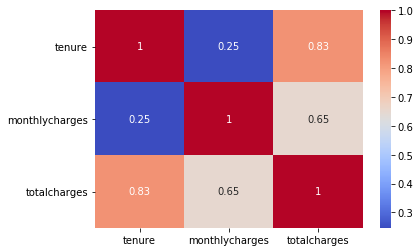

In [19]:
sns.heatmap(data=df[['tenure', 'monthlycharges', 'totalcharges']].corr(),
            annot=True, cmap='coolwarm');

***Inference:*** As evident from the correlation matrix and regplots, since ***'totalcharges'*** is the total monthly charges over the tenure of a customer, ***'totalcharges'*** is highly correlated with ***'monthlycharges'*** and ***'tenure'***.

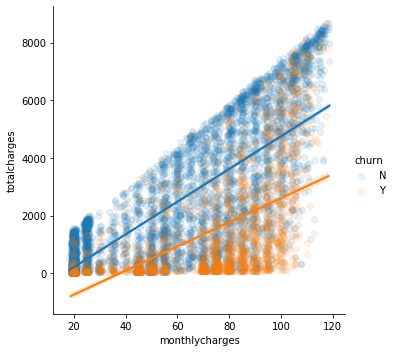

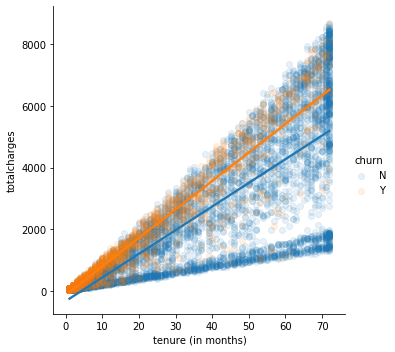

In [20]:
sns.lmplot('monthlycharges', 'totalcharges', data=df, hue='churn',
           scatter_kws={'alpha': 0.1})
fig = sns.lmplot('tenure', 'totalcharges', data=df, hue='churn',
                 scatter_kws={'alpha': 0.1})
fig.set_xlabels('tenure (in months)');

<a id="correlation-between-qualitative/-categorical-variables"></a>
## 2.2.  Correlation between Qualitative/ Categorical variables
`Cramer's V` is more appropriate than Pearson correlation to find correlation between two nominal variables. Here, the `Cramer's V` metric is implemented.

In [21]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [22]:
def categorical_corr_matrix(df):
    """
        Computes corrected Cramer's V statistic between
        all the categorical variables in the dataframe
    """
    df = df.select_dtypes(include='category')
    cols = df.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            df_crosstab = pd.crosstab(df[col1], df[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(df_crosstab)
    
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

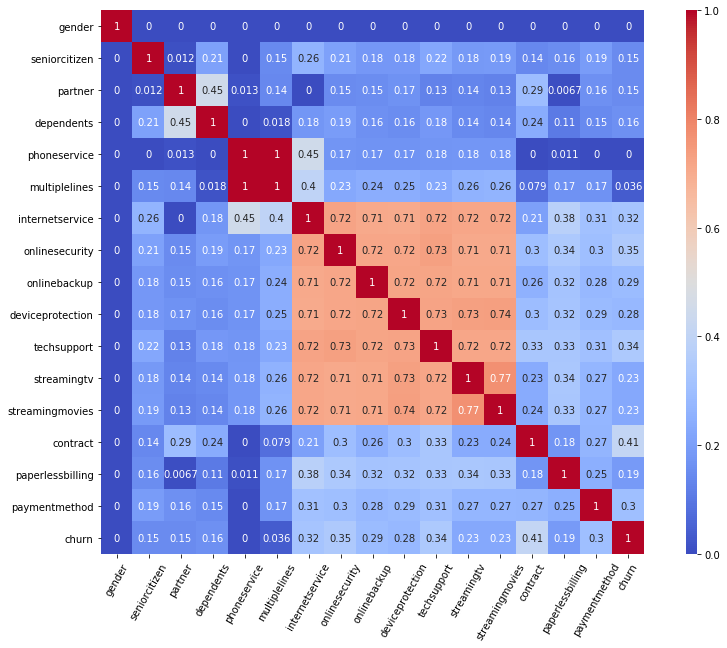

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(categorical_corr_matrix(df), annot=True, cmap='coolwarm', 
            cbar_kws={'aspect': 50}, square=True, ax=ax)
plt.xticks(rotation=60);

***Inference:*** There is some correlation between *'phone service'* and *'multiple lines'* since those who don't have a phone service cannot have multiple lines. So, knowing that a particular customer is not subscribed to phone service we can infer that the customer doesn't have multiple lines. Similarly, there is also a correlation between *'internet service'* and *'online security', 'online backup', 'device protection', 'streaming tv'* and *'streaming movies'*

<a id="data-visualization"></a>
# 3.  Data Visualization

<a id="frequency-distribution%3A-categorical-variables"></a>
## 3.1.  Frequency distribution: categorical variables

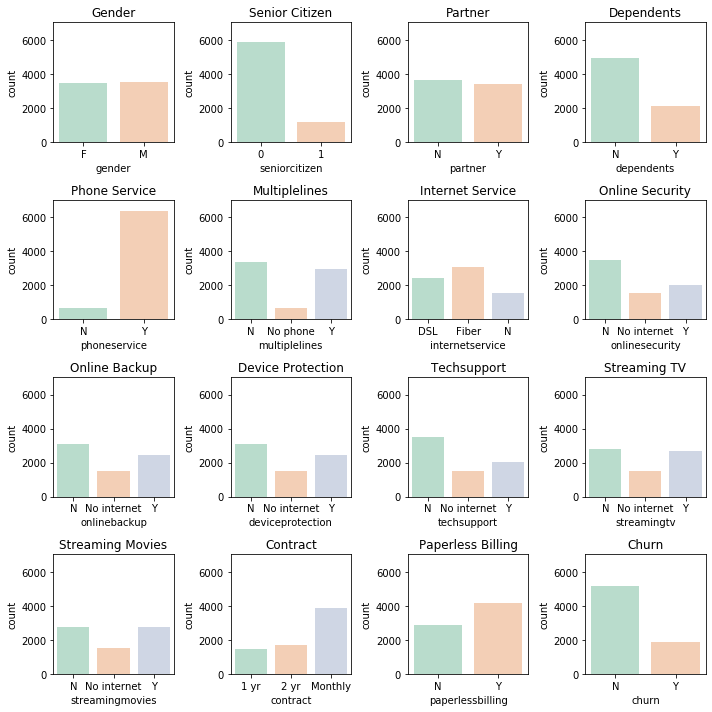

In [24]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
titles = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
          'Phone Service', 'Multiplelines', 'Internet Service', 'Online Security',
          'Online Backup', 'Device Protection', 'Techsupport', 'Streaming TV',
          'Streaming Movies', 'Contract', 'Paperless Billing', 'Churn']

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=''.join(title.lower().split()), data=df, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 7032)

plt.tight_layout()

<a id="frequency-distribution%3A-monthlycharges-and-tenure"></a>
## 3.2.  Frequency distribution: monthlycharges and tenure

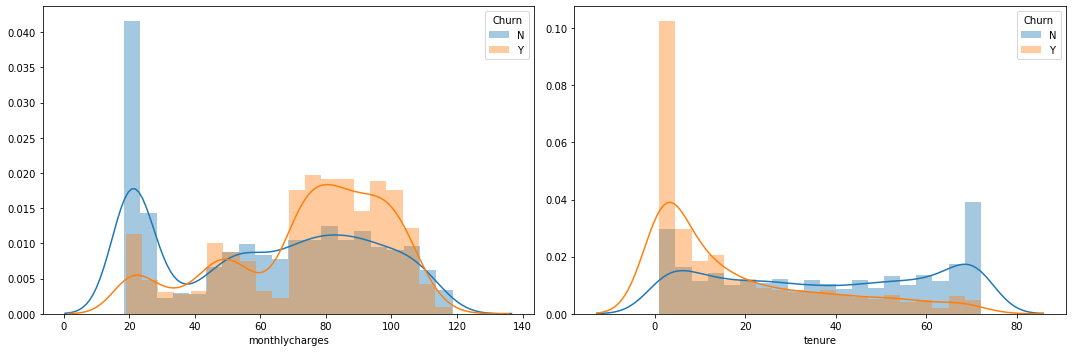

In [25]:
df_grouped = df.groupby(by='churn')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
cols = ['monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.distplot(df_grouped.get_group('N')[cols[i]], bins=20, ax=axes[i], label='N')
    sns.distplot(df_grouped.get_group('Y')[cols[i]], bins=20, ax=axes[i], label='Y')
    axes[i].legend(title='Churn')

fig.tight_layout()

***Inference:*** We can say that most churn customers have monthly charges of around 70 to 110 and a tenure of around 0 to 20 months.

<a id="box-plots"></a>
## 3.3.  Box Plots

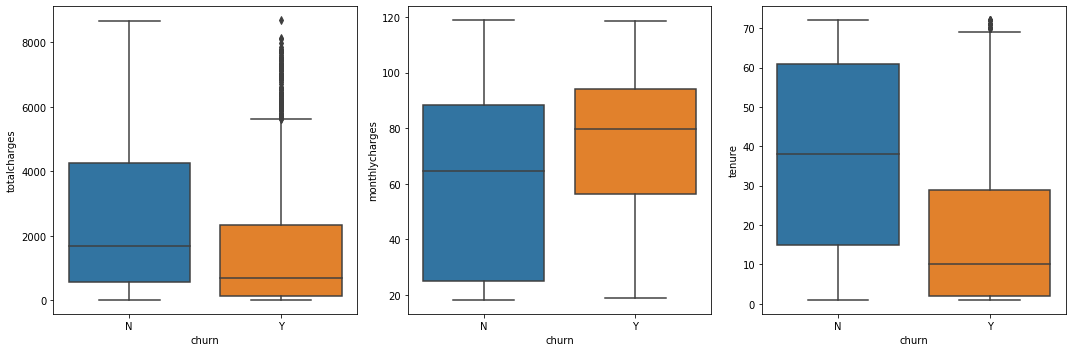

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
cols = ['totalcharges', 'monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.boxplot(x='churn', y=cols[i], data=df, ax=axes[i])
fig.tight_layout()

<a id="contribution-to-churned-revenue"></a>
## 3.4.  Contribution to churned revenue
Following graph represents percent contributed by customers in each tenure bin to the lost/ churned revenue.

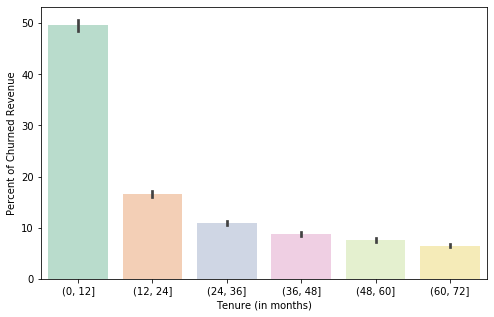

In [27]:
churned_users = df_grouped.get_group('Y')
bins = [(0, 12), (12, 24), (24, 36), (36, 48), (48, 60), (60, 72)]
binned_tenure = pd.cut(list(churned_users['tenure']),
                       bins=pd.IntervalIndex.from_tuples(bins))
revenue_share = churned_users['monthlycharges'] / churned_users['monthlycharges'].sum()
temp_df = pd.DataFrame(data={'tenure':binned_tenure, 
                             'revenue_share(%)': revenue_share * 100})


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.barplot(x='tenure', y='revenue_share(%)', data=temp_df,
            estimator=np.sum, palette='Pastel2', ax=ax)
ax.set_xlabel('Tenure (in months)')
ax.set_ylabel('Percent of Churned Revenue');

***Inference:*** Within the churned customers, 50% of the churned revenue is contributed by short tenure customers. This also means that the monthly charges of short tenure customers are more than high tenure customers. Therefore, if the ML models are successful in identifying the low tenure customers, then a major chunk of the revenue can be retained.

<a id="churn-among-different-contract-types"></a>
## 3.5.  Churn among different contract types

contract,1 yr,2 yr,Monthly
churn,,,
N,1306,1637,2220
Y,166,48,1655


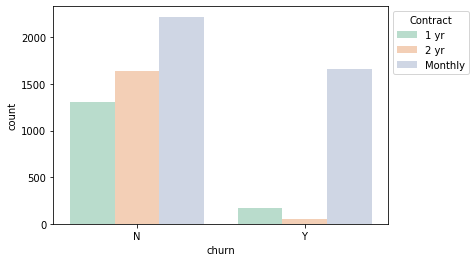

In [28]:
display(pd.crosstab(df['churn'], df['contract'], dropna=False))
sns.countplot(x='churn', hue='contract', data=df, palette='Pastel2')

# Put the legend out of the figure
plt.legend(title='Contract', bbox_to_anchor=(1, 1));

<a id="churn-among-various-categories-and-their-contribution-to-%28monthly%29-revenue"></a>
## 3.6.  Churn among various categories and their contribution to (monthly) revenue

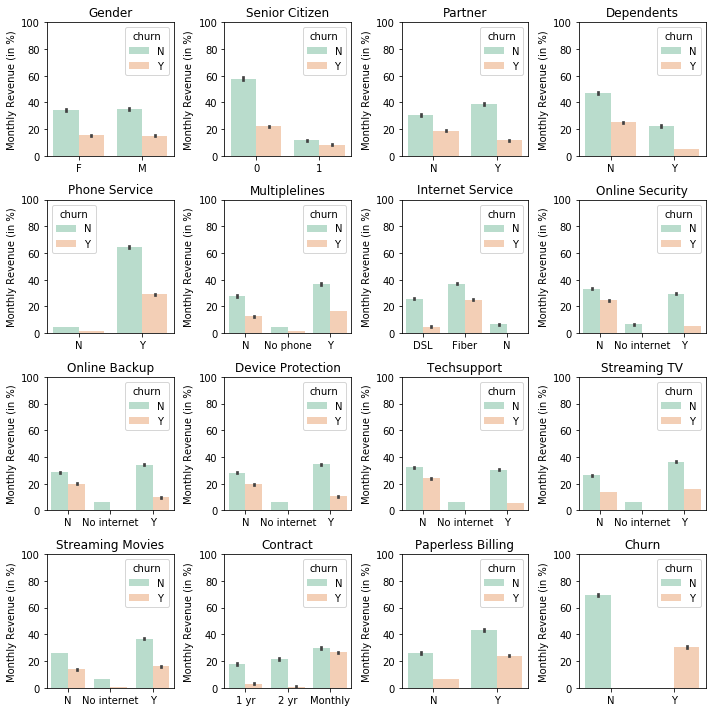

In [29]:
## Adding new column to the dataframe temporarily
# When the dataframe is grouped later, the estimator in `barplot`
# will give groupwise revenue share
df['share'] = (df['monthlycharges'] * 100) / df['monthlycharges'].sum()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
titles = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
          'Phone Service', 'Multiplelines', 'Internet Service', 'Online Security',
          'Online Backup', 'Device Protection', 'Techsupport', 'Streaming TV',
          'Streaming Movies', 'Contract', 'Paperless Billing', 'Churn']

## axs.flat is an attribute and contains a flattened axs vector/ list
ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.barplot(x=''.join(title.lower().split()), y='share', hue='churn', data=df,
                estimator=np.sum, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('Monthly Revenue (in %)')

fig.tight_layout()

***Inference:*** We can say that majority of the churned customers are not senior citizens, have dependents, are subscribed to phone service, Fiber internet, and paperless billing, are not subscribed to online security and tech support, and have monthly contracts.

In [30]:
## Remove the 'share' column
df.drop(labels=['share'], axis=1, inplace=True)

# 4. Data Preprocessing
#### Data needs to be one-hot-encoded before applying machine learning models.

In [31]:
categorical_cols = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
       'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'contract', 'paperlessbilling', 'paymentmethod']

df = pd.get_dummies(df, columns = categorical_cols)

We then replcae values of the target variable Churn from N and Y to 0 and 1.

In [32]:
conv = {'N': 0, 'Y': 1}
df.replace(to_replace=conv, inplace=True)
df['churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7032, dtype: int64

In [33]:
X = df.drop(['churn'], axis=1)
y = df['churn']

#### The data is then scaled using the MinMaxScaler

In [34]:
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

# 5. Data Modeling
#### We build machine learning models which are trained on the imbalanced classification dataset.

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101)

We split the dataset in the ratio of 80:20 as training and validation sets respectively.

In [36]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

We define functions for computing the RMSE (Root Mean Squared Error) of a model and printing the computed score.

In [37]:
classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['LogisticRegression :', LogisticRegression(solver='lbfgs', max_iter=1000)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()],
               ['CatBoost :', CatBoostClassifier(logging_level='Silent')]]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_valid

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_valid)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_valid, predictions))

DecisionTree : 0.7263681592039801
RandomForest : 0.7882018479033405
Naive Bayes : 0.6886993603411514
KNeighbours : 0.7746979388770433
SVM : 0.8088130774697939
LogisticRegression : 0.814498933901919
ExtraTreesClassifier : 0.767590618336887
AdaBoostClassifier : 0.8123667377398721
GradientBoostingClassifier:  0.8081023454157783
XGB : 0.7846481876332623
CatBoost : 0.8038379530916845


The imbalanced classification dataset is trained on various machine learning algorithms achieving accuracy rates as shown.

In [38]:
m = RandomForestClassifier(oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04422166387140533, 0.45477799827888565, 0.9980444444444444, 0.7931769722814499, 0.7856]


We train the dataset using a Random Forest Classifier in order to check feature importance of the model so that we can get an idea about the features which have the biggest influence on the model.

In [39]:
predicted = m.predict(X_valid)
report = classification_report(y_valid, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1052
           1       0.61      0.50      0.55       355

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407



A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report.

Here, we can see that the data instances which have the churn attribute '1' have poor scores. This is because the dataset is imbalanced and the instances where the churn attribute is '1' are the minority class. Hence the poor result in this specific class is expected.

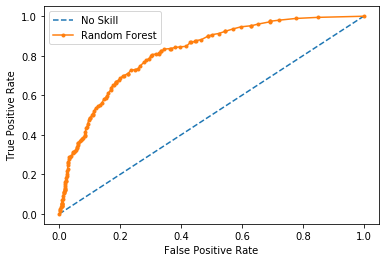

In [40]:
yhat = m.predict_proba(X_valid)
pos_probs = yhat[:, 1]
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(y_valid, pos_probs)
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Feature Importance

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.

In [41]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

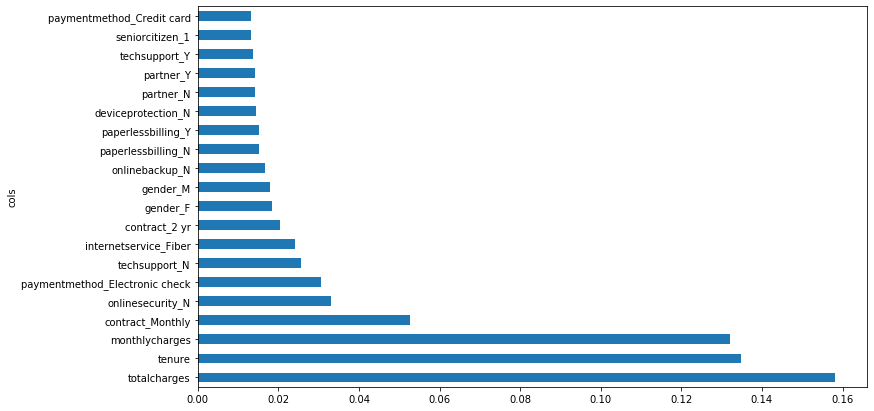

In [42]:
fi = rf_feat_importance(m, X_train)
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:20])
plt.show()

Here we can see the most important features. The higher the value, the more it influences the model in taking decisions. 'totalcharges', 'tenure' and 'monthlycharges' are the three most important features here.

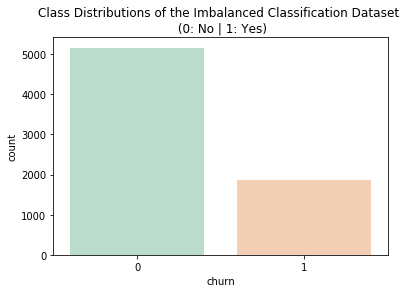

In [43]:
sns.countplot(x=y, palette='Pastel2')
plt.title('Class Distributions of the Imbalanced Classification Dataset \n (0: No | 1: Yes)', fontsize=12)
plt.show()

This is how the target variable 'churn' is distributed. We can see that the dataset is imbalanced.

Counter({0: 5163, 1: 1869})


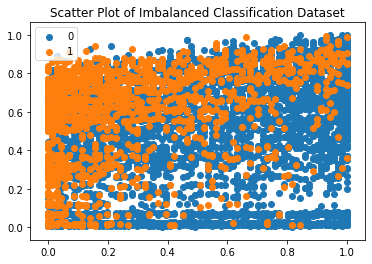

In [44]:
counter = Counter(y)
print(counter)
X_val, y_val = X.values, y.values
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_val == label)[0]
    plt.scatter(X_val[row_ix, 0], X_val[row_ix, 1], label=str(label))
plt.title('Scatter Plot of Imbalanced Classification Dataset')
plt.legend()
plt.show()

This is a scatter plot showing how the data instances are distributed of both '0' and '1' classes belonging to the 'churn' attribute.

In [45]:
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression(solver='lbfgs', max_iter=1000)
clf3 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('gnb', clf1), ('lr', clf2), ('xgb', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_valid)
print(accuracy_score(y_valid, predictions))

0.8102345415778252


We then built a Voting Classifier consisting of a Gradient Boosting Classifier, a Logistic Regression Classifier and an XGB Classifier. A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

In [46]:
report = classification_report(y_valid, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1052
           1       0.65      0.53      0.58       355

    accuracy                           0.81      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407



Here, it can be seen that the score of class '0' is substantially better than class '1'. This is because the dataset contains more instances of class '0' than class '1'.

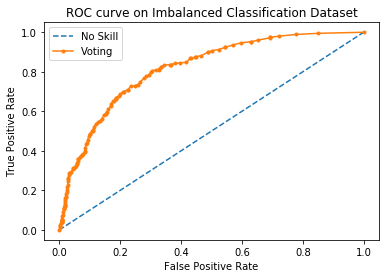

In [47]:
yhat = m.predict_proba(X_valid)
pos_probs = yhat[:, 1]
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(y_valid, pos_probs)
plt.plot(fpr, tpr, marker='.', label='Voting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on Imbalanced Classification Dataset')
plt.legend()
plt.show()

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate. The above graph is an ROC curve of the Voting Classifier trained on the imbalanced dataset.

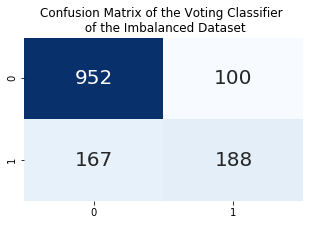

In [48]:
cm = confusion_matrix(y_valid, predictions)
plt.figure(figsize=(5, 3))
plt.title('Confusion Matrix of the Voting Classifier \n of the Imbalanced Dataset')
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 20})
plt.show()

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. Here, we can see the confusion matrix of the Voting Classifier trained on the imbalanced dataset.

# 6. NearMiss Undersampling

Undersampling refers to a group of techniques designed to balance the class distribution for a classification dataset that has a skewed class distribution.

We use the NearMiss technique to undersample the imbalanced classification dataset. Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.
We chose version-1 of the technique which selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class.

In [49]:
undersample = NearMiss(version=1, n_neighbors=3)
X_under, y_under = undersample.fit_resample(X, y)

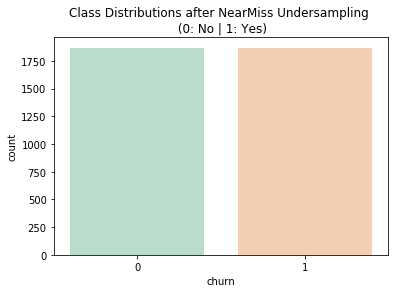

In [50]:
sns.countplot(x=y_under, palette='Pastel2')
plt.title('Class Distributions after NearMiss Undersampling \n (0: No | 1: Yes)', fontsize=12)
plt.show()

After Undersampling the dataset, we can see that there are equal instances of both classes of count 1869.

Counter({0: 1869, 1: 1869})


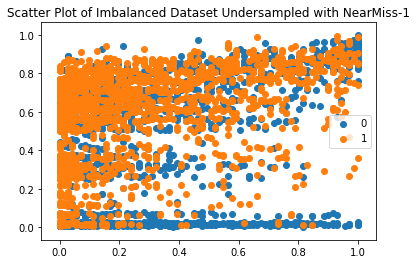

In [51]:
counter = Counter(y_under)
print(counter)
X_val, y_val = X_under.values, y_under.values
for label, _ in counter.items():
    row_ix = np.where(y_val == label)[0]
    plt.scatter(X_val[row_ix, 0], X_val[row_ix, 1], label=str(label))
plt.title('Scatter Plot of Imbalanced Dataset Undersampled with NearMiss-1')
plt.legend()
plt.show()

This is a scatter plot showing how the data instances are distributed of both '0' and '1' classes belonging to the 'churn' attribute after undersampling with NearMiss-1.

In [52]:
Xu_train, Xu_valid, yu_train, yu_valid = train_test_split(X_under, y_under, test_size=0.2, random_state=101)

In [53]:
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression(solver='lbfgs', max_iter=1000)
clf3 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('gnb', clf1), ('lr', clf2), ('xgb', clf3)], voting='soft')
eclf1.fit(Xu_train, yu_train)
pred_under = eclf1.predict(Xu_valid)
print(accuracy_score(yu_valid, pred_under))

0.7058823529411765


The accuracy comes down to 70% as we have reduced the data that the Voting Classifier is trained on.

In [54]:
report = classification_report(yu_valid, pred_under)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       365
           1       0.69      0.78      0.73       383

    accuracy                           0.71       748
   macro avg       0.71      0.70      0.70       748
weighted avg       0.71      0.71      0.70       748



Here, it can be observed that after Undersampling, the score of the class '0' suffers because we reduced the instances of it while the score of class '1' improves as it now has the same number of instances as class '0'.

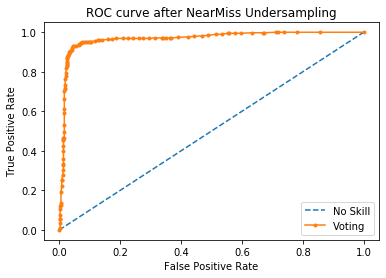

In [55]:
yhat = m.predict_proba(Xu_valid)
pos_probs = yhat[:, 1]
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(yu_valid, pos_probs)
plt.plot(fpr, tpr, marker='.', label='Voting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve after NearMiss Undersampling')
plt.legend()
plt.show()

This is an ROC curve showing the TPR and FPR of the Voting Classifier after UnderSampling.

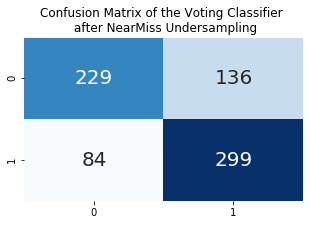

In [56]:
cm_under = confusion_matrix(yu_valid, pred_under)
plt.figure(figsize=(5, 3))
plt.title('Confusion Matrix of the Voting Classifier \n after NearMiss Undersampling')
sns.heatmap(cm_under,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 20})
plt.show()

This is the confusion matrix describing the performance of the Voting Classifier after Undersampling the dataset.

# 7. SMOTE Oversampling

Oversampling can be achieved by synthesize new examples from the minority class in the training dataset prior to fitting a model. This is a type of data augmentation which can be very effective.
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [57]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_smote, y_smote = sm.fit_sample(X, y)

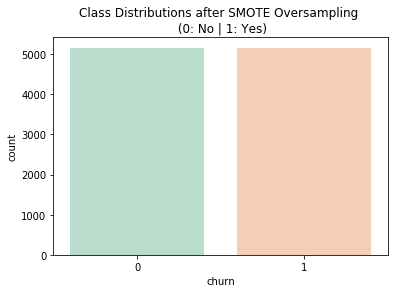

In [58]:
sns.countplot(x=y_smote, palette='Pastel2')
plt.title('Class Distributions after SMOTE Oversampling \n (0: No | 1: Yes)', fontsize=12)
plt.show()

After Oversampling the dataset, we can see that there are equal instances of both classes of count 5163.

Counter({0: 5163, 1: 5163})


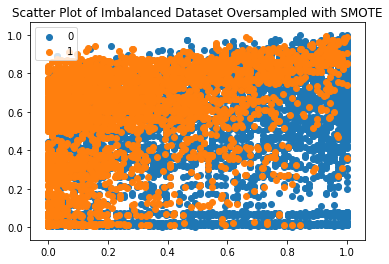

In [59]:
counter = Counter(y_smote)
print(counter)
X_val, y_val = X_smote.values, y_smote.values
for label, _ in counter.items():
    row_ix = np.where(y_val == label)[0]
    plt.scatter(X_val[row_ix, 0], X_val[row_ix, 1], label=str(label))
plt.title('Scatter Plot of Imbalanced Dataset Oversampled with SMOTE')
plt.legend()
plt.show()

In [60]:
Xs_train, Xs_valid, ys_train, ys_valid = train_test_split(X_smote, y_smote, test_size=0.2, random_state=101)

In [61]:
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression() 
clf3 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('gnb', clf1), ('lr', clf2), ('xgb', clf3)], voting='soft')
eclf1.fit(Xs_train, ys_train)
pred_smote = eclf1.predict(Xs_valid)
print(accuracy_score(ys_valid, pred_smote))

0.8543078412391094


The accuracy increases to 85.4% after implemengting SMOTE as we have created new examples for the minority class that the Voting Classifier is trained on.

In [62]:
report = classification_report(ys_valid, pred_smote)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1030
           1       0.83      0.89      0.86      1036

    accuracy                           0.85      2066
   macro avg       0.86      0.85      0.85      2066
weighted avg       0.86      0.85      0.85      2066



Here, it can be observed that after Oversampling, the score of class '1' improves as it now has the same number of instances as class '0' and the dataset is balanced.

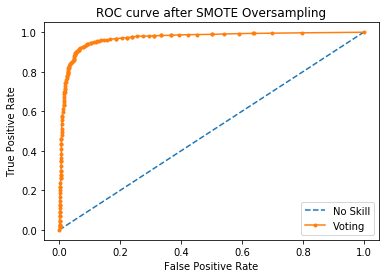

In [63]:
yhat = m.predict_proba(Xs_valid)
pos_probs = yhat[:, 1]
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(ys_valid, pos_probs)
plt.plot(fpr, tpr, marker='.', label='Voting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve after SMOTE Oversampling')
plt.legend()
plt.show()

This is an ROC curve showing the TPR and FPR of the Voting Classifier after Oversampling.

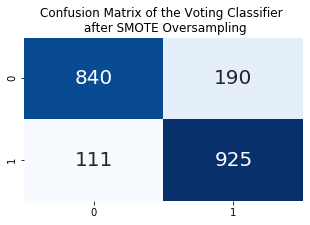

In [64]:
cm_smote = confusion_matrix(ys_valid, pred_smote)
plt.figure(figsize=(5, 3))
plt.title('Confusion Matrix of the Voting Classifier \n after SMOTE Oversampling')
sns.heatmap(cm_smote,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 20})
plt.show()

This is the confusion matrix describing the performance of the Voting Classifier after Oversampling the dataset.